In [1]:
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.optimizers import *
from keras.applications import *
from keras.applications import imagenet_utils
from keras.preprocessing.image import *
from keras.utils import multi_gpu_model

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from glob import glob
from tqdm import tqdm
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.metrics import *
from collections import Counter

import multiprocessing
from multiprocessing.dummy import Pool
from pprint import pprint

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
n_gpus = len(os.environ['CUDA_VISIBLE_DEVICES'].split(','))

Using TensorFlow backend.


In [2]:
batch_size = 4 * n_gpus
model_name = ''
preprocess_func = inception_resnet_v2.preprocess_input
MODEL = InceptionResNetV2

f = 2.5
width = int(2560 / f)
height = int(1920 / f)
classes = ['正常', '吊经', '擦洞', '跳花', '毛洞', '织稀', '扎洞', '缺经', '毛斑', '其他']
n_classes = len(classes)

In [18]:
idg = ImageDataGenerator(horizontal_flip=True,
                         rotation_range=5,
                         zoom_range=0.1)
gen_test = idg.flow_from_directory('testb', target_size=(height, width), shuffle=False, 
                                   interpolation='lanczos', class_mode=None, batch_size=batch_size)

Found 647 images belonging to 1 classes.


# 按 val_auc 排序

In [4]:
a = [(x[x.rfind('-')+1:x.rfind('.')], x) for x in glob('models/*.h5')]
a = sorted(a, key=lambda x:x[0], reverse=True)[:50]
a

[('0.962335', 'models/irv2_0731-0.001001-120-0.962335.h5'),
 ('0.954866', 'models/irv2_0802-0.001000-30-0.954866.h5'),
 ('0.954225', 'models/irv2_0801-0.000100-60-0.954225.h5'),
 ('0.937116',
  'models/InceptionResNetV2_0803_f3.0_reg4e-05-0.000100-67-0.937116.h5'),
 ('0.936927',
  'models/InceptionResNetV2_0803_f2.5_reg4e-05-0.000100-58-0.936927.h5'),
 ('0.935714',
  'models/InceptionResNetV2_0803_f2.5_reg4e-05-0.000100-67-0.935714.h5'),
 ('0.935391',
  'models/InceptionResNetV2_0803_f2.5_reg4e-05-0.000100-59-0.935391.h5'),
 ('0.934825',
  'models/InceptionResNetV2_0803_f2.5_reg4e-05-0.001000-39-0.934825.h5'),
 ('0.934690',
  'models/InceptionResNetV2_0803_f2.5_reg4e-05-0.000100-68-0.934690.h5'),
 ('0.934557', 'models/irv2_0802_f3.75-0.000100-56-0.934557.h5'),
 ('0.934420',
  'models/InceptionResNetV2_0803_f2.5_reg4e-05-0.001000-31-0.934420.h5'),
 ('0.934340',
  'models/InceptionResNetV2_0803_f2.5_reg4e-05-0.000100-66-0.934340.h5'),
 ('0.934219', 'models/irv2_0802-0.001000-29-0.934219.

# 构建模型

In [5]:
base_model = MODEL(include_top=False, weights=None)
input_tensor = Input((None, None, 3))
x = Lambda(preprocess_func)(input_tensor)
x = base_model(x)
x = GlobalAvgPool2D()(x)
x = Dense(n_classes, activation='softmax')(x)
model = Model(input_tensor, x)

In [6]:
model_parallel = multi_gpu_model(model, n_gpus)

# 预测结果

In [7]:
def predict(fname_model):
    model.load_weights(fname_model)
    y_pred = model_parallel.predict_generator(gen_test, verbose=1, workers=multiprocessing.cpu_count())
    
    y_pred2 = 1 - y_pred[:,0]
    
    plt.figure()
    plt.hist(y_pred2);
    
    # 直接 clip 法
    y_pred4 = np.round(y_pred2, 6).clip(1e-6, 1-1e-6)
    
    # 排序法
    table = np.linspace(0.1, 0.9, num=y_pred2.shape[0])
    index = np.argsort(y_pred2)
    y_pred3 = np.zeros(y_pred2.shape)
    y_pred3[index] = table
    
    fname_model2 = fname_model[fname_model.rfind('/')+1:]
    with open(f'outs/pred_{fname_model2}_3.csv', 'w') as f:
        f.write('filename,probability\n')
        for fname, value in zip(gen_test.filenames, y_pred3):
            fname = fname[fname.rfind('/')+1:]
            f.write(f'{fname},{value:.6f}\n')

    with open(f'outs/pred_{fname_model2}_4.csv', 'w') as f:
        f.write('filename,probability\n')
        for fname, value in zip(gen_test.filenames, y_pred4):
            fname = fname[fname.rfind('/')+1:]
            f.write(f'{fname},{value:.6f}\n')
    return y_pred

# f2.5

Found 647 images belonging to 1 classes.
81/81 [==============================] - 35s 433ms/step


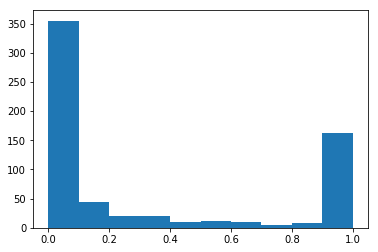

In [24]:
f = 2.5
width = int(2560 / f)
height = int(1920 / f)

fname_model = 'models/InceptionResNetV2_0803_f2.5_reg4e-05-0.000100-70-0.932102.h5'
model.load_weights(fname_model)

idg = ImageDataGenerator(horizontal_flip=True,
                         rotation_range=5,
                         zoom_range=0.1)
gen_test = idg.flow_from_directory('testb', target_size=(height, width), shuffle=False, 
                                    interpolation='lanczos', batch_size=batch_size)
y_preds = [model_parallel.predict_generator(gen_test, verbose=1, 
                                            workers=multiprocessing.cpu_count()) for i in range(8)]

y_pred = np.mean(y_preds, axis=0)
y_pred2 = 1 - y_pred[:,0]
plt.figure()
plt.hist(y_pred2);

# 排序法
table = np.linspace(0.1, 0.9, num=y_pred2.shape[0])
index = np.argsort(y_pred2)
y_pred3 = np.zeros(y_pred2.shape)
y_pred3[index] = table

fname_model2 = fname_model[fname_model.rfind('/')+1:]
with open(f'outs/pred_{fname_model2}_5.csv', 'w') as f:
    f.write('filename,probability\n')
    for fname, value in zip(gen_test.filenames, y_pred3):
        fname = fname[fname.rfind('/')+1:]
        f.write(f'{fname},{value:.6f}\n')

# f3

Found 647 images belonging to 1 classes.
81/81 [==============================] - 29s 358ms/step


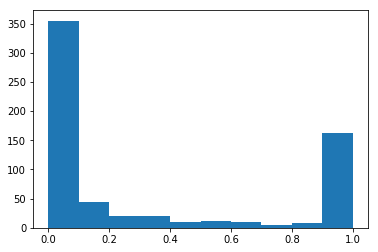

In [25]:
f = 3
width = int(2560 / f)
height = int(1920 / f)

fname_model = 'models/InceptionResNetV2_0803_f3.0_reg4e-05-0.000100-70-0.929757.h5'
model.load_weights(fname_model)

idg = ImageDataGenerator(horizontal_flip=True,
                         rotation_range=5,
                         zoom_range=0.1)
gen_test = idg.flow_from_directory('testb', target_size=(height, width), shuffle=False, 
                                    interpolation='lanczos', batch_size=batch_size)
y_preds2 = [model_parallel.predict_generator(gen_test, verbose=1, 
                                            workers=multiprocessing.cpu_count()) for i in range(8)]

y_pred = np.mean(y_preds, axis=0)
y_pred2 = 1 - y_pred[:,0]
plt.figure()
plt.hist(y_pred2);

# 排序法
table = np.linspace(0.1, 0.9, num=y_pred2.shape[0])
index = np.argsort(y_pred2)
y_pred3 = np.zeros(y_pred2.shape)
y_pred3[index] = table

fname_model2 = fname_model[fname_model.rfind('/')+1:]
with open(f'outs/pred_{fname_model2}_5.csv', 'w') as f:
    f.write('filename,probability\n')
    for fname, value in zip(gen_test.filenames, y_pred3):
        fname = fname[fname.rfind('/')+1:]
        f.write(f'{fname},{value:.6f}\n')

In [26]:
for i in range(len(y_preds)):
    y_pred = np.mean(y_preds[:i+1] + y_preds2[:i+1], axis=0)
    y_pred2 = 1 - y_pred[:,0]
    
    table = np.linspace(0.1, 0.9, num=y_pred2.shape[0])
    index = np.argsort(y_pred2)
    y_pred3 = np.zeros(y_pred2.shape)
    y_pred3[index] = table
    
    with open(f'outs/ensemble_f2.5_f3_{i}.csv', 'w') as f:
        f.write('filename,probability\n')
        for fname, value in zip(gen_test.filenames, y_pred3):
            fname = fname[fname.rfind('/')+1:]
            f.write(f'{fname},{value:.6f}\n')